In [234]:
import numpy as np
import random
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque 
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

# 설정
SEED = 0
BATCH_SIZE = 64
LR = 1e-4
GAMMA = 0.99
EPISODES = 5000
MEMORY_SIZE = 10000
TARGET_UPDATE = 10
HIDDEN_SIZE = 128
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 5000

In [235]:
class DRQN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DRQN, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden=None):
        out, _ = self.rnn(x)
        q_values = self.fc(out)
        return q_values

In [236]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=self.capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [237]:
def optimize_model() :
    if len(memory) < BATCH_SIZE :
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = list(zip(*transitions))

    dummy_state = torch.zeros_like(batch[0][0]).to(device)

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch[3])), dtype=torch.bool).to(device)
    non_final_next_states = torch.cat([s for s in batch[3] if s is not None]).to(device)

    state_batch = torch.cat(batch[0]).to(device)
    action_batch = torch.cat(batch[1]).to(device)
    reward_batch = torch.cat(batch[2]).to(device)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE).to(device)

    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = nn.MSELoss()(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [238]:
env = gym.make('CartPole-v1')
n_actions = env.action_space.n
n_states = env.observation_space.shape[0]
device = torch.device("cuda")
policy_net = DRQN(n_states, HIDDEN_SIZE, n_actions).float().to(device)
target_net = DRQN(n_states, HIDDEN_SIZE, n_actions).float().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayMemory(MEMORY_SIZE)

 80%|███████▉  | 3980/5000 [05:23<01:23, 12.28it/s]


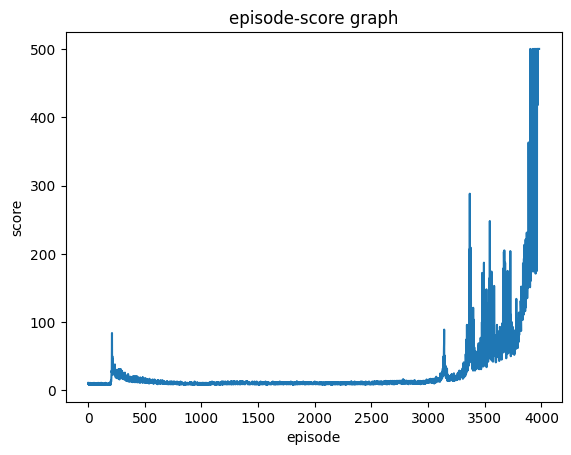

In [244]:
time_step = 0
rewards_list = []
for episode in tqdm(range(EPISODES)) :
    time_step += 1
    state = torch.tensor([env.reset()[0]], dtype=torch.float32).to(device)
    reward_value = 0
    while True :
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * time_step / EPS_DECAY)
        if random_value > 0.8 :
            action = torch.tensor([[random.choice([0, 1])]]).to(device)
        else :
            action = policy_net(state).max(1)[1].view(1, 1)
        #print(action)
        next_state, reward, done1, done2, _ = env.step(action.item())
        reward_value += 1
        reward = torch.tensor([reward], dtype=torch.float32).to(device)
        done = done1 or done2

        if not done :
            next_state = torch.tensor([next_state], dtype=torch.float32).to(device)
        else :
            next_state = None
        memory.push((state, action, reward, next_state))
        state = next_state

        optimize_model()
        if done :
            break
    rewards_list.append(reward_value)
    if episode % TARGET_UPDATE == 0 :
        target_net.load_state_dict(policy_net.state_dict())
        if len(rewards_list) > 3 and sum(rewards_list[-3:]) == 1500 :
            break
env.close()
plt.plot(rewards_list)
plt.title('episode-score graph')
plt.xlabel('episode')
plt.ylabel('score')
plt.savefig('main_dqn.png')
plt.show()